# Dictionary Analysis

In [17]:
import pandas as pd
from tqdm import tqdm

In [18]:
rpx_dict = pd.read_csv("dictionary_analysis/rpc_lex.csv", delimiter=";")
rpx_dict

,term,category_code,category_de,category_en,dereko_frequency
0,-etage,SCAN,Skandalisierung,Scandalization,NaN
1,#abgase,SCAN,Skandalisierung,Scandalization,NaN
2,#kreuzfahrtschiffe,SCAN,Skandalisierung,Scandalization,NaN
3,#schwerölverbrennung,SCAN,Skandalisierung,Scandalization,NaN
4,#umweltskandal,SCAN,Skandalisierung,Scandalization,NaN
...,...,...,...,...,...
14100,wurzelrassenlehre,ESO,(Rechts-)Esoterik,Esotericism,NaN
14101,z-plan,ESO,(Rechts-)Esoterik,Esotericism,NaN
14102,zahlenmystik,ESO,(Rechts-)Esoterik,Esotericism,NaN
14103,zeitenwende,ESO,(Rechts-)Esoterik,Esotericism,"9810,00000000000"


In [45]:
def get_dictionary_analysis_term_occurence(text: list):
    term_occurrence = 0
    identified_terms = []
    for term in rpx_dict.term.to_list():
        if term in text:
            term_occurrence+=1
            identified_terms.append((term))
    return term_occurrence, identified_terms

In [46]:
comments = pd.read_csv("data/youtube_comments_500.csv")
comments["Comments"] = comments["Comments"].astype(str)
dict_term_occurrence_list = []
dict_identified_terms_list = []

for text in tqdm(comments.Comments.to_list()):
    occurence, identified_terms = get_dictionary_analysis_term_occurence(text)
    dict_term_occurrence_list.append(occurence)
    dict_identified_terms_list.append(identified_terms)

100%|██████████| 406242/406242 [12:41<00:00, 533.82it/s]


In [48]:
comments["dict_term_occurrence"] = dict_term_occurrence_list
comments["dict_identified_terms_list"] = dict_identified_terms_list
comments.loc[comments['dict_term_occurrence'] > 0]

,Unnamed: 0,Comments,dict_term_occurrence,dict_identified_terms_list
0,0,wollt ihr jetzt jeden tag einen großen bericht...,33,"[ganz, große, großen, bericht, ganz, großen, s..."
1,1,"Wenn Scholz alles besser weiss, wieso braucht ...",20,"[brauch, braucht, weiss, wieso, wie, wieso, be..."
2,2,Die Grünen hatten Früher das Peace Zeichen als...,22,"[heute, wen, wenig, heute, wächst, heute, weni..."
3,3,Der Westen ist ein Kriegstreiber bis es zu ein...,29,"[kommt, krieg, lange, weit, kommt, lange, mach..."
4,4,Frieden schaffen ohne Waffen.,4,"[schaf, schaffen, schaffen, schaffen]"
...,...,...,...,...
406237,406237,"Kann jeder deutscher werden ,kein Problem sola...",59,"[arbeit, gehen, lange, deutsche, lange, überwa..."
406238,406238,Dann nimm die Leute bei dir auf und verpflege ...,4,"[halt, eu, halt, halt]"
406239,406239,🙄🤔als Staatenloser hatt mans aber auch nicht l...,7,"[treiben, stimmt, treiben, ss, nich, nich, tt]"
406240,406240,Wann kommt der Blackout? Kinder könnt ihr ja e...,22,"[kommt, kommt, schützen, kommt, kommt, kommt, ..."


array([[<AxesSubplot: title={'center': 'dict_term_occurrence'}>]],
      dtype=object)

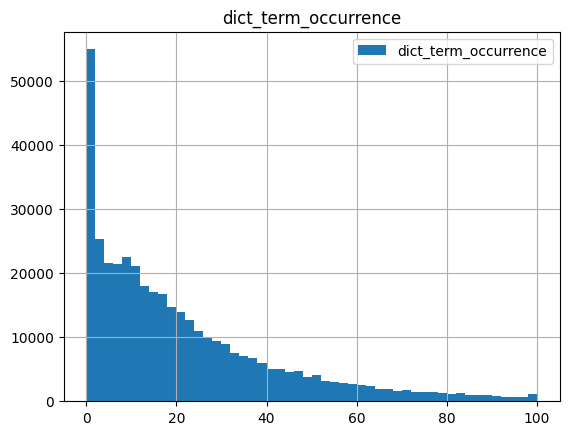

In [63]:
comments.hist(column="dict_term_occurrence", legend=True, bins=50, range=[0,100])